In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

focal_length = 970.0
baseline = 50.0
data_path = "HW1-1-data"
data_path_save = "HW1-1-output"

pairs = ["1262", "1755", "1131", "0000"]

num_disparities = 512
block_size = 7


Colorbar Function

In [6]:
def add_colorbar(image, cmap_height=256, bar_width=20):
    """Add a vertical colorbar to the right of the image"""
    colorbar = np.zeros((cmap_height, bar_width, 3), dtype=np.uint8)
    for i in range(cmap_height):
        colorbar[i, :] = cv2.applyColorMap(
            np.array([[i]], dtype=np.uint8), cv2.COLORMAP_JET
        )[0, 0]
    # Resize colorbar to match image height
    colorbar = cv2.resize(colorbar, (bar_width, image.shape[0]))
    return np.hstack((image, colorbar))


cv2.imshow function for inline viewing in notebook

In [7]:
def cv2_imshow_nb(img, title=""):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:  
        plt.imshow(img, cmap="gray")
    else:  
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


Processing


Processing pair: 1262


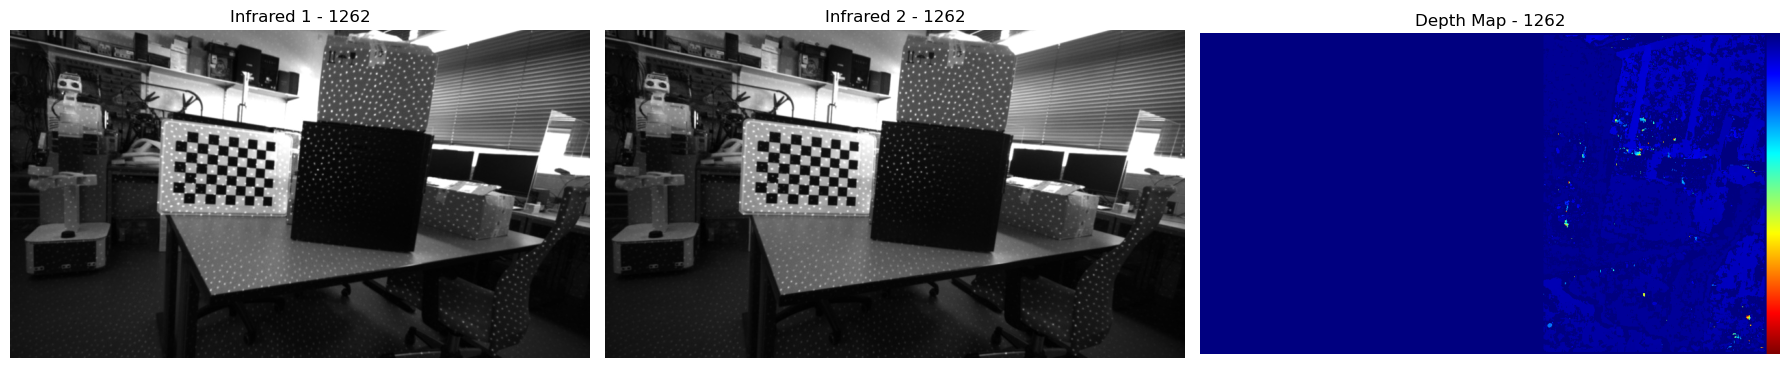


Processing pair: 1755


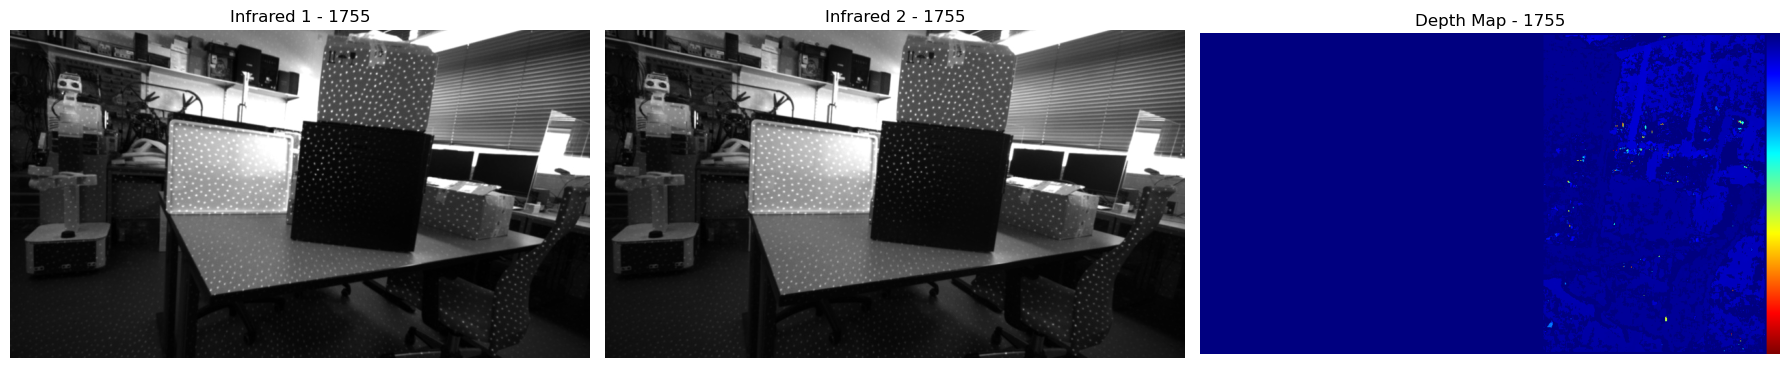


Processing pair: 1131


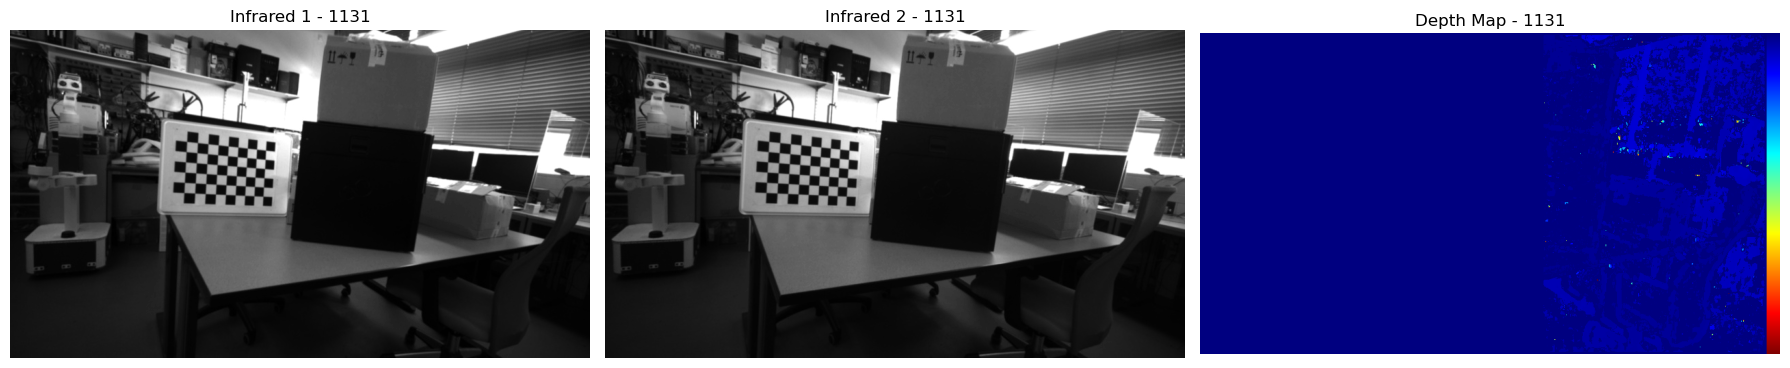


Processing pair: 0000


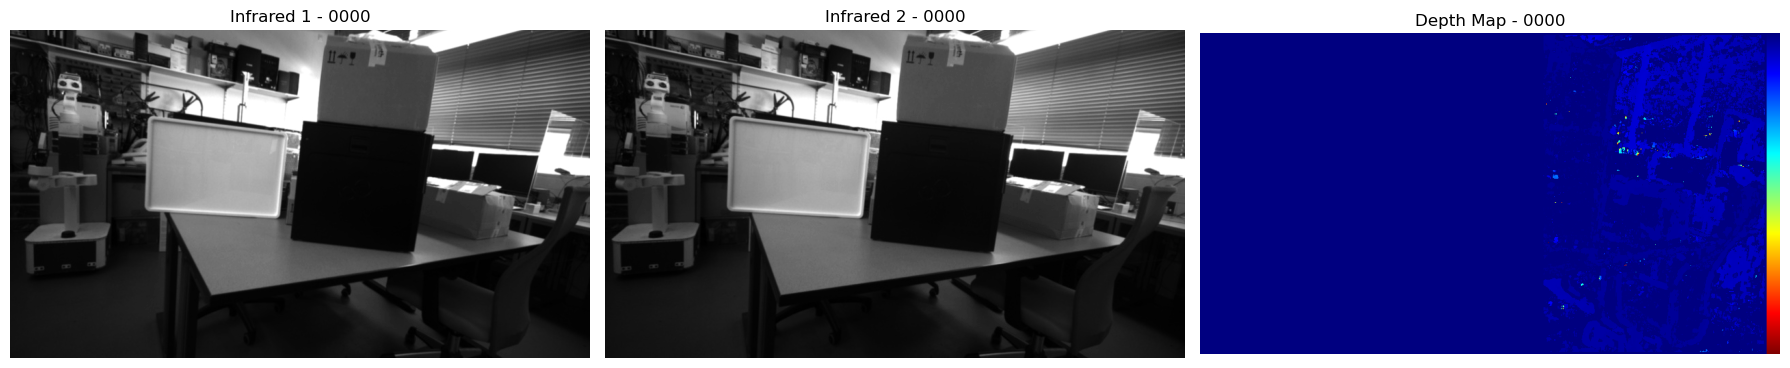

In [8]:
for pair_id in pairs:
    print(f"\nProcessing pair: {pair_id}")

    # Load images
    ir1 = cv2.imread(
        os.path.join(data_path, f"infra1_{pair_id}.jpg"), cv2.IMREAD_GRAYSCALE
    )
    ir2 = cv2.imread(
        os.path.join(data_path, f"infra2_{pair_id}.jpg"), cv2.IMREAD_GRAYSCALE
    )
    color = cv2.imread(os.path.join(data_path, f"color{pair_id}.jpg"))

    if ir1 is None or ir2 is None or color is None:
        print(f"Could not load images for pair {pair_id}")
        continue

    # Compute disparity map
    stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    disparity = stereo.compute(ir1, ir2).astype(np.float32) / 16.0
    disparity[disparity <= 0] = np.nan

    # Compute depth
    depth = (focal_length * baseline) / disparity

    # Normalize depth and apply color map
    depth_vis = cv2.normalize(
        np.nan_to_num(depth, nan=0.0), None, 0, 255, cv2.NORM_MINMAX
    ).astype(np.uint8)
    depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

    # Add colorbar
    depth_color_bar = add_colorbar(depth_color)

    # Display images inline using cv2.imshow
    # Display IR1, IR2, Depth in a single row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # IR1
    axes[0].imshow(ir1, cmap="gray")
    axes[0].set_title(f"Infrared 1 - {pair_id}")
    axes[0].axis("off")

    # IR2
    axes[1].imshow(ir2, cmap="gray")
    axes[1].set_title(f"Infrared 2 - {pair_id}")
    axes[1].axis("off")

    # DEPTH
    axes[2].imshow(cv2.cvtColor(depth_color_bar, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Depth Map - {pair_id}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Save output
    os.makedirs(data_path_save, exist_ok=True)
    cv2.imwrite(os.path.join(data_path_save, f"depth_{pair_id}.jpg"), depth_color_bar)


The checkerboard provides high contrast features (edges, corners, patterns) making it easier for the algorithm to find correspondences between the stereo images, leading to more accurate disparity and depth estimation.

In contrast, a plane without texture (the PC case) looks almost identical across neighboor pixels. As a result, the stereo matching cannot find that good correspondences, leading to poor disparity and depth estimation.

Laser pattern adds artificial detail and contrast, which help textureless regions to match better. Result is higher quality disparity and depth maps.

Images without laser pattern depend entirely on natural textures, which may be insufficient in some areas, leading to lower quality disparity and depth maps.